In [23]:
import os
import pandas as pd

filename = os.path.join(*['data', 'current_data', 'concated'])
df = pd.read_csv(filename, sep=';')

print(df.shape)
df.head()

(20, 55)


,cloudcover,day,maxtemp,mintemp,precipMM,pressure,windspeed,cloudcover.1,maxtemp.1,mintemp.1,...,mintemp.7,precipMM.7,pressure.7,windspeed.7,cloudcover.8,maxtemp.8,mintemp.8,precipMM.8,pressure.8,windspeed.8
0,1,278,21,12,0.0,1028,7,1,17,7,...,11,0.0,1030,12,15,24,8,0.0,1025,4
1,13,279,23,12,0.0,1020,12,6,20,10,...,13,0.0,1026,10,57,20,13,10.2,1020,7
2,39,280,24,15,0.1,1015,7,48,20,13,...,12,0.0,1019,9,61,20,12,5.0,1015,6
3,30,281,24,15,0.0,1019,6,13,19,10,...,16,0.0,1019,6,59,18,11,11.3,1019,4
4,6,282,26,16,0.0,1023,5,4,21,10,...,15,0.0,1024,12,34,20,11,0.0,1022,5


In [24]:
# Load model, best weights and scaler

from keras.models import load_model
from sklearn.externals import joblib

model = load_model('model.h5')
model.load_weights("weights.hdf5")
scaler = joblib.load("scaler.save") 

In [25]:
import numpy as np

# Convert dataframe to numpy array
current_data = np.array(df)

# Print last element
print(current_data[-1])

# Set current day num to last know day's number
current_day_num = current_data[-1][1]
print(current_day_num)

[5.400e+01 2.970e+02 1.400e+01 1.100e+01 5.200e+00 1.009e+03 3.000e+01
 5.500e+01 1.100e+01 9.000e+00 6.400e+00 1.011e+03 3.100e+01 4.300e+01
 9.000e+00 7.000e+00 4.100e+00 1.005e+03 2.300e+01 8.200e+01 1.300e+01
 1.200e+01 4.900e+00 1.009e+03 2.400e+01 3.800e+01 2.100e+01 1.100e+01
 0.000e+00 1.014e+03 9.000e+00 1.000e+02 1.200e+01 1.100e+01 2.400e+00
 1.021e+03 2.600e+01 8.300e+01 7.000e+00 5.000e+00 6.200e+00 9.990e+02
 3.800e+01 5.100e+01 1.800e+01 1.300e+01 2.000e-01 1.003e+03 3.000e+01
 6.400e+01 1.500e+01 9.000e+00 1.600e+00 1.014e+03 8.000e+00]
297.0


In [26]:
# Scale data
current_data = scaler.transform(current_data)
print(current_data[0])

[0.01       0.28099174 0.7        0.64864865 0.         0.74545455
 0.16129032 0.01       0.71052632 0.62162162 0.         0.74545455
 0.34375    0.01       0.57142857 0.60526316 0.         0.76923077
 0.1        0.         0.61363636 0.64864865 0.         0.74
 0.14814815 0.06       0.70731707 0.72972973 0.         0.72727273
 0.12       0.         0.725      0.72222222 0.         0.67857143
 0.16666667 0.21       0.65853659 0.58333333 0.         0.73584906
 0.4        0.02       0.63636364 0.675      0.         0.82692308
 0.31428571 0.15       0.81395349 0.73170732 0.         0.72
 0.06666667]


In [27]:
# Make predictions

# Prediction from last 20 days
last_days = current_data[-20:]

# Predict next 60 days
prediction_range = 60

for days in range(prediction_range):
    current_day_num += 1
    d = current_data[-20:].reshape(-1) # Flatten data
    d = np.expand_dims(d, axis=0) # NN waits for array, we use just 1 day as input
    next_day = model.predict(d, batch_size=1)
    next_day = scaler.inverse_transform(next_day) # Inverse transform day to correct values
    next_day[0][1] = current_day_num # Day number can be corrected
    next_day = scaler.transform(next_day) # Transform back
    current_data = np.append(current_data, next_day, axis=0) # Add prediction to known days

In [28]:
# Make inverse transformation to get real values
result = scaler.inverse_transform(current_data)

In [29]:
# Convert day number to date

import datetime
def dateOfDay(day):
    return (datetime.datetime(2018, 1, 1) + datetime.timedelta(day-1)).date()

In [34]:
# Convert result to dataframe

result_df = pd.DataFrame(columns=['day', 'date', 'max', 'min', 'avg', 'pressure', 'cloudcover', 'precipMM', 'windspeed'])
for day in result:
    day_num = int(round(day[1]))
    result_df = result_df.append({'day': day_num,
                      'date': dateOfDay(day_num),
                      'max': day[2],
                      'min': day[3],
                      'avg': (day[2] + day[3])/2,
                      'pressure': day[5],
                      'cloudcover': day[0],
                      'precipMM': day[4],
                      'windspeed': day[6]}, ignore_index=True)

In [35]:
pd.options.display.max_rows = None
result_df

,day,date,max,min,avg,pressure,cloudcover,precipMM,windspeed
0,278,2018-10-05,21.000000,12.000000,16.500000,1028.000000,1.000000,0.000000,7.000000
1,279,2018-10-06,23.000000,12.000000,17.500000,1020.000000,13.000000,0.000000,12.000000
2,280,2018-10-07,24.000000,15.000000,19.500000,1015.000000,39.000000,0.100000,7.000000
3,281,2018-10-08,24.000000,15.000000,19.500000,1019.000000,30.000000,0.000000,6.000000
4,282,2018-10-09,26.000000,16.000000,21.000000,1023.000000,6.000000,0.000000,5.000000
5,283,2018-10-10,24.000000,15.000000,19.500000,1025.000000,34.000000,0.000000,6.000000
6,284,2018-10-11,24.000000,17.000000,20.500000,1024.000000,3.000000,0.000000,8.000000
7,285,2018-10-12,24.000000,16.000000,20.000000,1027.000000,3.000000,0.000000,5.000000
8,286,2018-10-13,26.000000,17.000000,21.500000,1028.000000,1.000000,0.000000,5.000000
9,287,2018-10-14,23.000000,15.000000,19.000000,1025.000000,2.000000,0.000000,9.000000


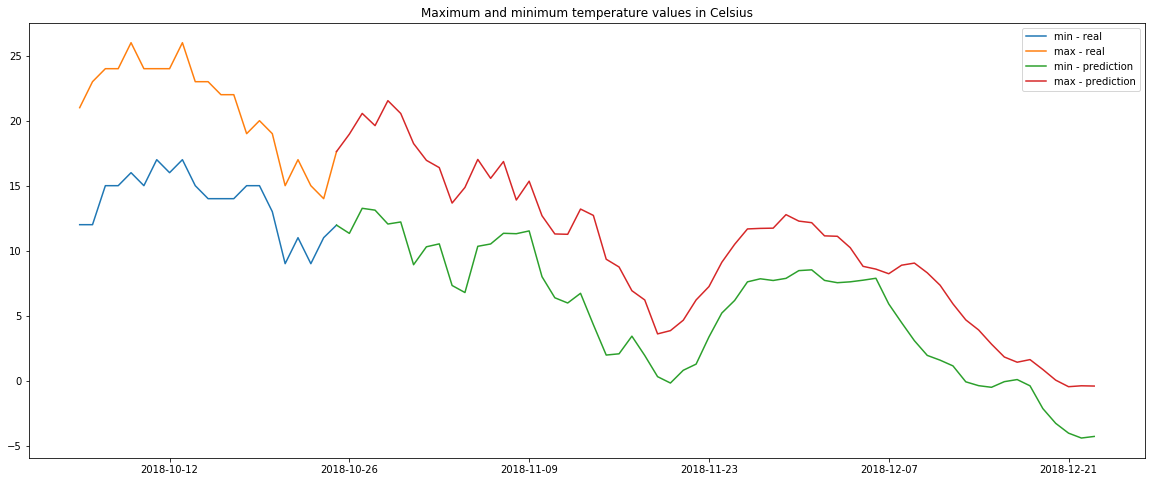

In [36]:
# Print some nice graph in next few boxes

from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8))
plt.title('Maximum and minimum temperature values in Celsius')
plt.plot(result_df['date'][:21], result_df['min'][:21])
plt.plot(result_df['date'][:21], result_df['max'][:21])
plt.plot(result_df['date'][20:], result_df['min'][20:])
plt.plot(result_df['date'][20:], result_df['max'][20:])

plt.legend(['min - real', 'max - real', 'min - prediction', 'max - prediction'], loc='upper right')
plt.show()

In [43]:
# Solution of Exercise 3

print(result_df.loc[result_df['date'].isin([datetime.datetime(2018, 10, 26).date(),
                                            datetime.datetime(2018, 11, 1).date(),
                                            datetime.datetime(2018, 11, 29).date()]),
                    ['date', 'avg']])

          date        avg
21  2018-10-26  15.147974
27  2018-11-01  13.624382
55  2018-11-29  10.321313


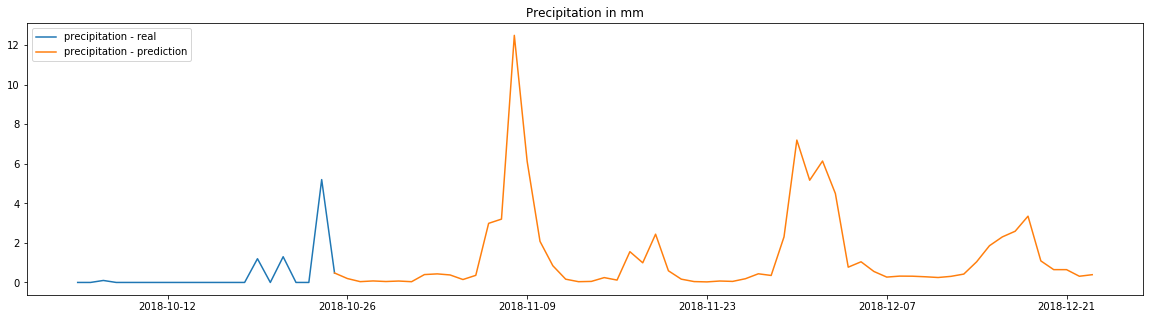

In [44]:
plt.figure(figsize=(20,5))
plt.title('Precipitation in mm')
plt.plot(result_df['date'][:21], result_df['precipMM'][:21])
plt.plot(result_df['date'][20:], result_df['precipMM'][20:])

plt.legend(['precipitation - real', 'precipitation - prediction'], loc='upper left')
plt.show()

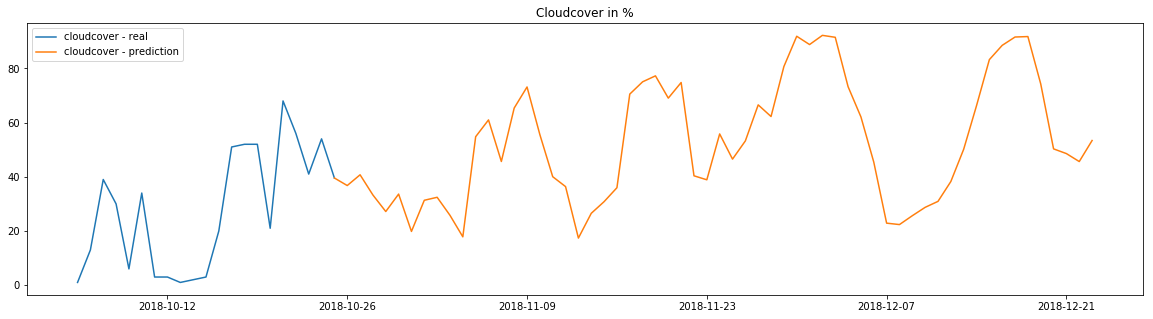

In [45]:
plt.figure(figsize=(20,5))
plt.title('Cloudcover in %')
plt.plot(result_df['date'][:21], result_df['cloudcover'][:21])
plt.plot(result_df['date'][20:], result_df['cloudcover'][20:])

plt.legend(['cloudcover - real', 'cloudcover - prediction'], loc='upper left')
plt.show()

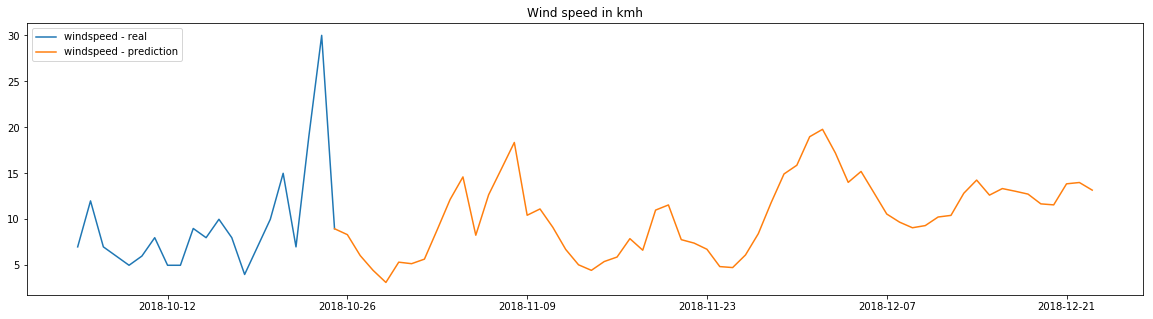

In [46]:
plt.figure(figsize=(20,5))
plt.title('Wind speed in kmh')
plt.plot(result_df['date'][:21], result_df['windspeed'][:21])
plt.plot(result_df['date'][20:], result_df['windspeed'][20:])

plt.legend(['windspeed - real', 'windspeed - prediction'], loc='upper left')
plt.show()